In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('/global/homes/f/fnafis/KrSTC/analysis/physrev.mpl')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as adf
from scipy.fft import fft


In [2]:
a = np.array([1,2,4,8])
a[:-1]

array([1, 2, 4])

In [12]:
tsm = pd.read_csv('TSM_historical_data.csv')
tsm['Close-Open'] = tsm['Close'] - tsm['Open']
tsm['good_day'] = (tsm['Close'] - tsm['Open'])*tsm['Volume']/1e6
tsm['adj_good_day'] = tsm['good_day']-tsm['good_day'].min()+1
tsm['Date'] = pd.to_datetime(tsm['Date'])
# drop na
tsm = tsm.dropna()
tsm

,Date,Open,High,Low,Close,Adj Close,Volume,Close-Open,good_day,adj_good_day
1,2019-05-13,41.369999,41.509998,40.740002,40.990002,35.890339,11046000,-0.379997,-4.197447,326.398892
2,2019-05-14,41.590000,42.080002,41.400002,41.970001,36.748413,7107800,0.380001,2.700971,333.297310
3,2019-05-15,41.549999,42.330002,41.459999,41.970001,36.748413,5347700,0.420002,2.246045,332.842384
4,2019-05-16,41.630001,41.639999,41.220001,41.529999,36.363152,9214700,-0.100002,-0.921488,329.674851
5,2019-05-17,40.389999,40.950001,40.090000,40.250000,35.242405,11271000,-0.139999,-1.577929,329.018410
...,...,...,...,...,...,...,...,...,...,...
1255,2024-05-06,140.470001,142.830002,139.809998,142.830002,142.830002,8601600,2.360001,20.299785,350.896124
1256,2024-05-07,141.869995,142.289993,140.509995,141.110001,141.110001,8682900,-0.759994,-6.598952,323.997387
1257,2024-05-08,141.110001,144.259995,140.800003,143.600006,143.600006,10202300,2.490005,25.403778,356.000117
1258,2024-05-09,142.940002,143.350006,141.130005,142.789993,142.789993,8003000,-0.150009,-1.200522,329.395817


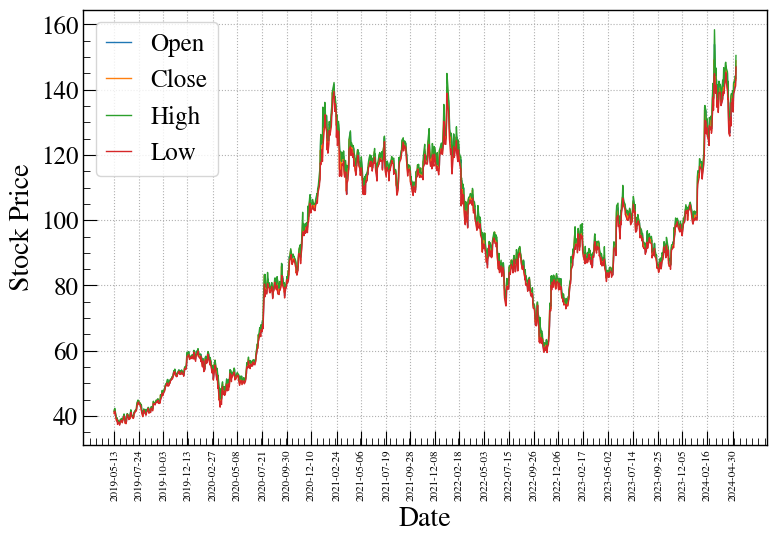

In [13]:
lw = 1
plt.plot(tsm['Date'], tsm['Open'], label='Open', linewidth=lw)
plt.plot(tsm['Date'], tsm['Close'], label='Close', linewidth=lw)
plt.plot(tsm['Date'], tsm['High'], label='High', linewidth=lw)
plt.plot(tsm['Date'], tsm['Low'], label='Low', linewidth=lw)
plt.xlabel('Date')
plt.ylabel('Stock Price')
# skip every 10th date
plt.xticks(tsm['Date'][::50])
# rotate x-axis labels
plt.xticks(rotation=90, fontsize=8)

plt.legend()

Is the data stationary? Should not be! Let's see by ADF (Augmented Dickey-Fuller) test.

In [16]:
adf(tsm['good_day'])

(-16.715981494408535,
 1.4215877218994112e-29,
 3,
 1255,
 {'1%': -3.435571295403709,
  '5%': -2.863845736356174,
  '10%': -2.567997600196822},
 11684.105949992769)

Interpretation of ADF test: If p-value is less than 0.05, we reject the null hypothesis that the data is non-stationary. If p-value is greater than 0.05, we fail to reject the null hypothesis that the data is non-stationary.
Here, p-value is 0.000000, which is less than 0.05. So, we reject the null hypothesis that the data is non-stationary. So, the data is stationary! Which is surprising, because the data is clearly not stationary. This is because the data is not independent? (GPT suggested that)

# Seasonality check
Seasonal decomposition is basically fitting data with a model of a seasonal component + a trend (+ other things like and error term may be etc.). But the final result from statsmodel seems quite complicated, don't have the intution for that

Text(0, 0.5, 'Sum of residuals for additive model')

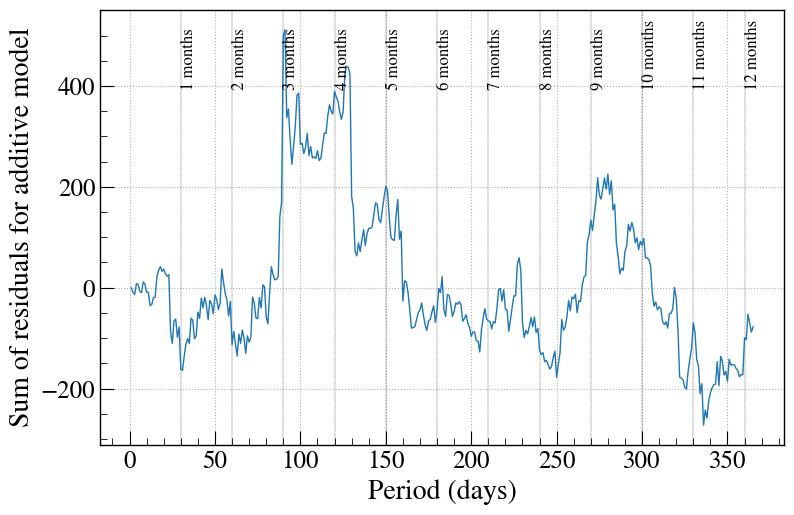

In [5]:
# plt.plot(tsm['Date'], tsm['good_day'], lw=1)

periods = [i for i in range(1,366,1)]
residual_sums_additive = []
residual_sums_multiplicative = []
for p in periods:
    decompose_result_additive = seasonal_decompose(tsm['good_day'], model='additive', period=p) # additive just means linear trend with seasonality, but in practice seems more complicated
    # # decompose_result_multiplicative = seasonal_decompose(tsm['adj_good_day'], model='multiplicative', period=p) # multiplicative means non-linear trend with seasonality
    residual_sums_additive.append(decompose_result_additive.resid.sum())
    # residual_sums_multiplicative.append(decompose_result_multiplicative.resid.sum())

months = [i for i in range(30, 366, 30)]
# plot verticle lines at month intervals and annotate them as 'x months'
fig, ax = plt.subplots(1)
for month in months:
    ax.axvline(x=month, color='k', linestyle='--', lw=0.25)
    ax.text(month, 400, f'{month//30} months', rotation=90, fontsize=12, color='k')


ax.plot(periods, residual_sums_additive, lw=1, label='Additive')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Sum of residuals for additive model')
# second y axis
# ax2 = plt.twinx()
# ax2.plot(periods, residual_sums_multiplicative, lw=1, label='Multiplicative')

# ax2.set_ylabel('Sum of residuals for multiplicative model')
# a = plt.xticks(tsm['Date'][::50], rotation=90, fontsize=8)

Text(0, 0.5, 'Strength of the trend \n(0 is best, deviation is bad)')

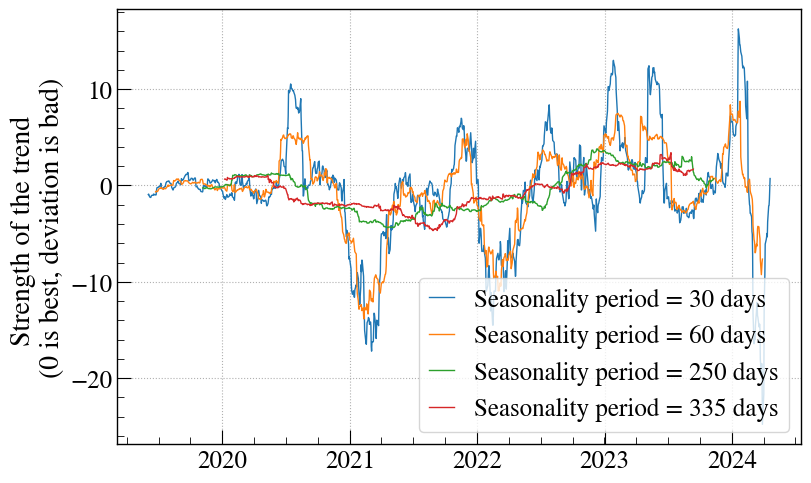

In [6]:
for p in [30, 60, 250, 335]:
    decompose_result_additive = seasonal_decompose(tsm['good_day'], model='additive', period=p)
    plt.plot(tsm['Date'], decompose_result_additive.trend, lw=1, label=f'Seasonality period = {p} days')
plt.legend()
plt.ylabel('Strength of the trend \n(0 is best, deviation is bad)')

What trends are people following every 250 and 335 days?

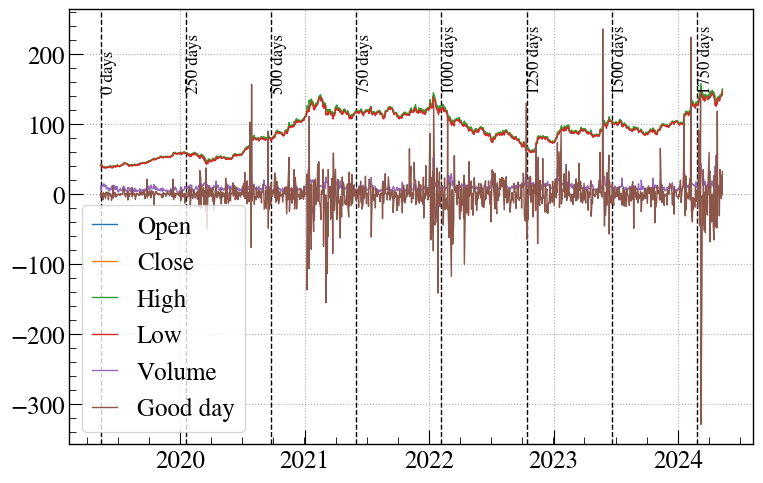

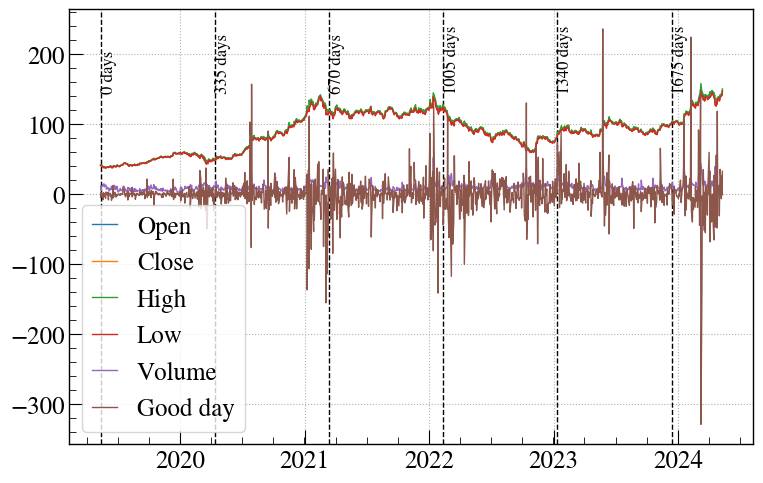

In [7]:

for trend_period in [250, 335]:
    fig, ax = plt.subplots(1)
    # dray verticle line at trend_period days
    total_days = tsm['Date'].max() - tsm['Date'].min()
    for i in range(0, total_days.days, trend_period):

        ax.axvline(x=tsm['Date'].min()+pd.Timedelta(days=i), color='k', linestyle='--', lw=1)
        ax.text(tsm['Date'].min()+pd.Timedelta(days=i), 150, f'{i} days', rotation=90, fontsize=12, color='k')
    ax.plot(tsm['Date'], tsm['Open'], lw=1, label='Open')
    ax.plot(tsm['Date'], tsm['Close'], lw=1, label='Close')
    ax.plot(tsm['Date'], tsm['High'], lw=1, label='High')
    ax.plot(tsm['Date'], tsm['Low'], lw=1, label='Low')
    ax.plot(tsm['Date'], tsm['Volume']/1e6, lw=1, label='Volume')
    ax.plot(tsm['Date'], tsm['good_day'], lw=1, label='Good day')
    plt.legend()


# Autocorrelation
We can ask if nth data point of a time series depends on how many previos data points. It'll be 1 at minimum and n-1 at maximum. This is called autocorrelation. But using n-1 can lead to overfitting, so we use a smaller number, called lag, usually denoted by p. It's a hyperparameter that we can tune by looking at the ACF plot (how? I don't know yet). 
Correlation among 

$t_{i} = \m_1 t_{i-1} + \epsilon_{i}$

In [ ]:
import statsmodels.api as sm

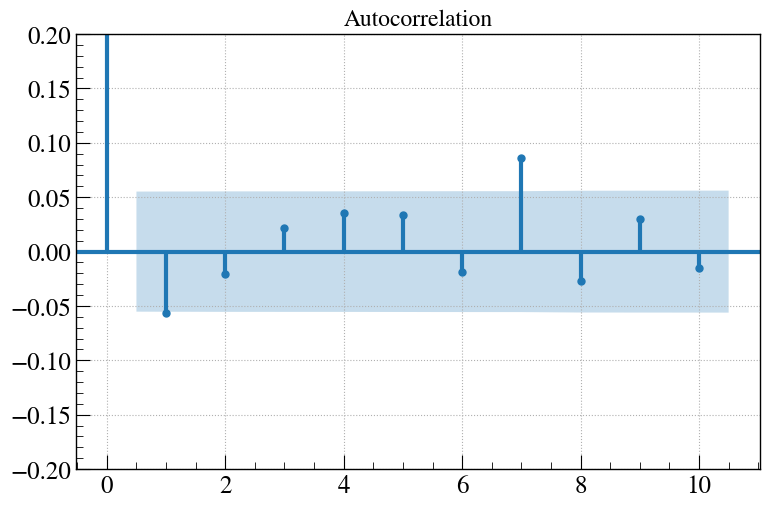

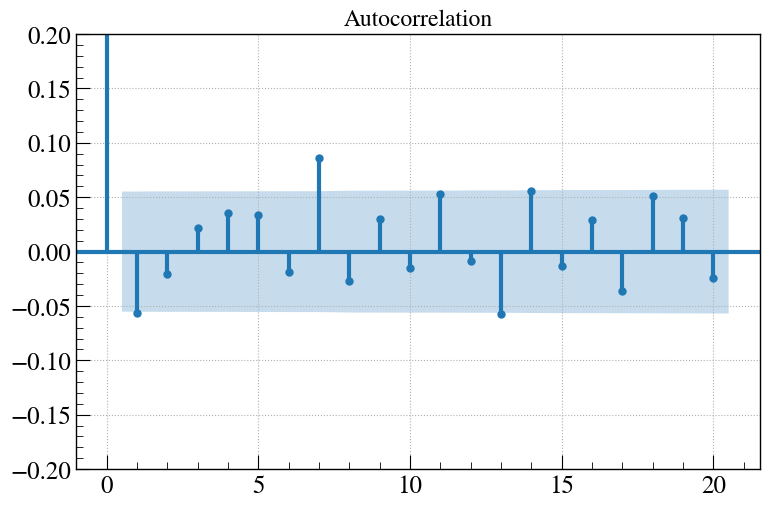

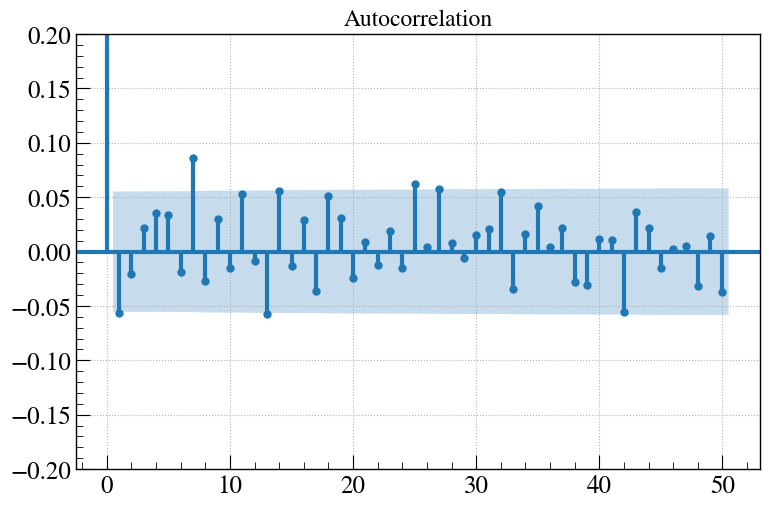

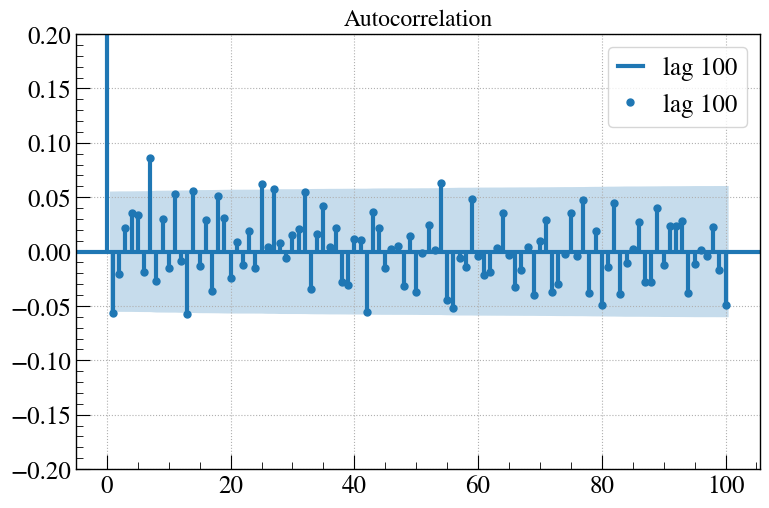

In [ ]:
sm.graphics.tsa.plot_acf(tsm['Close-Open'], lags=10, label='lag 10')
plt.ylim(-0.2, 0.2)
sm.graphics.tsa.plot_acf(tsm['Close-Open'], lags=20, label='lag 20')
plt.ylim(-0.2, 0.2)
sm.graphics.tsa.plot_acf(tsm['Close-Open'], lags=50, label='lag 50')
plt.ylim(-0.2, 0.2)
sm.graphics.tsa.plot_acf(tsm['Close-Open'], lags=100, label='lag 100')
plt.ylim(-0.2, 0.2)
plt.legend()
